In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from string import punctuation
import torch
from torch import nn
import re
from math import log
from datasets import load_dataset_builder
from datasets import load_dataset


In [9]:
# This cell clean the vader sentiment, removing words graded beetween -1 and 1 and setting negative grades to -1 and positive to 1

vader_lexicon = pd.read_csv("vader_lexicon.csv", delimiter="\t", names=["symbols", "grade"], usecols=[0,1])
vader_lexicon.loc[vader_lexicon.grade >= 1].grade = 1
vader_lexicon.loc[vader_lexicon.grade <= -1].grade = -1
vader_lexicon = vader_lexicon[(vader_lexicon.grade == 1) | (vader_lexicon.grade == -1)]
vader_lexicon.set_index("symbols", inplace=True)
vader_lexicon

/tmp/ipykernel_14204/1649606488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_lexicon.loc[vader_lexicon.grade >= 1].grade = 1
/tmp/ipykernel_14204/1649606488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_lexicon.loc[vader_lexicon.grade <= -1].grade = -1


,grade
symbols,
/^:,-1.0
:p,1.0
:^\,-1.0
:^|,-1.0
;-),1.0
...,...
wimps,-1.0
wisenheimer,-1.0
worshiper,1.0


In [10]:
# Load the data, clean the text and merge all the different train validation and test datasets into one
dataset = load_dataset("imdb")

all_data = {}

def clean_data(text_data):
    text_data = text_data.str.lower()
    text_data = text_data.str.replace("[" + punctuation + "]( |$)", "", regex=True)
    return text_data

for type in dataset.keys():
        
    text_data = pd.Series(dataset[type]["text"])

    text_data = clean_data(text_data=text_data)
    all_data[type] = pd.concat([text_data, pd.Series(dataset[type]["label"])], axis=1)
    all_data[type].columns=["text", "label"]
    
    
data = all_data["train"]
data

Dataset imdb downloaded and prepared to /home/aeschylli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 513.32it/s]


,text,label
0,i rented i am curious-yellow from my video sto...,0
1,"""i am curiousyellowis a risible and pretentiou...",0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard's ma...,0
4,ohbrother...after hearing about this ridiculou...,0
...,...,...
24995,a hit at the time but now better categorised a...,1
24996,i love this movie like no otheranother time i ...,1
24997,this film and it's sequel barry mckenzie holds...,1
24998,'the adventures of barry mckenziestarted life ...,1


In [11]:

data_set = ["I don't really know where this came from, but this movie, which was very clearly created to be for kids, has some real material built around solid bones. And that wolf was genuinely unnerving.", "meh; i didn't love it. it lost my attention eventually."]
data_set = pd.DataFrame(data, columns=["text", "label"])
data_set["text"] = data_set["text"].str.lower()

def grade(word : str):
  """
  return the grade of the word given in parameter in the vader lexicon if exists or 0 if it is not in.
  """
  try:
    x = vader_lexicon.loc[word].grade
  except KeyError:
    x = 0
  return x

# Each line produce a part of the required vector.
# The next cells will produces plots of those to better understand the repartition od datas
data_set["word list"] = data_set["text"].apply(lambda text : re.split("[" + punctuation + " ]", text))
data_set["no?"] = data_set["word list"].apply(lambda word_list : "no" in word_list).astype("int")
data_set["pronoun"] = data_set["word list"].apply(lambda word_list : word_list.count("i") + word_list.count("you"))
data_set["!?"] = data_set["text"].str.contains("!").astype("int")
data_set["log(nb word)"] = data_set["word list"].apply(len).apply(np.log)
data_set["word list"] = data_set["word list"].apply(lambda word_list : [grade(word) for word in word_list])
data_set["good_mood"] = data_set["word list"].apply(lambda word_list : word_list.count(1))
data_set["bad_mood"] = data_set["word list"].apply(lambda word_list : word_list.count(-1))


data_set


,text,label,word list,no?,pronoun,!?,log(nb word),good_mood,bad_mood
0,i rented i am curious-yellow from my video sto...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,4,0,5.686975,0,0
1,"""i am curiousyellowis a risible and pretentiou...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,5.327876,0,0
2,if only to avoid making this type of film in t...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,4.736198,0,0
3,this film was probably inspired by godard's ma...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,0,4.836282,0,0
4,ohbrother...after hearing about this ridiculou...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,8,1,5.897154,0,0
...,...,...,...,...,...,...,...,...,...
24995,a hit at the time but now better categorised a...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,4.564348,1,0
24996,i love this movie like no otheranother time i ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,6,1,5.393628,0,0
24997,this film and it's sequel barry mckenzie holds...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,0,4.955827,0,0
24998,'the adventures of barry mckenziestarted life ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,1,6.573680,1,0


array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

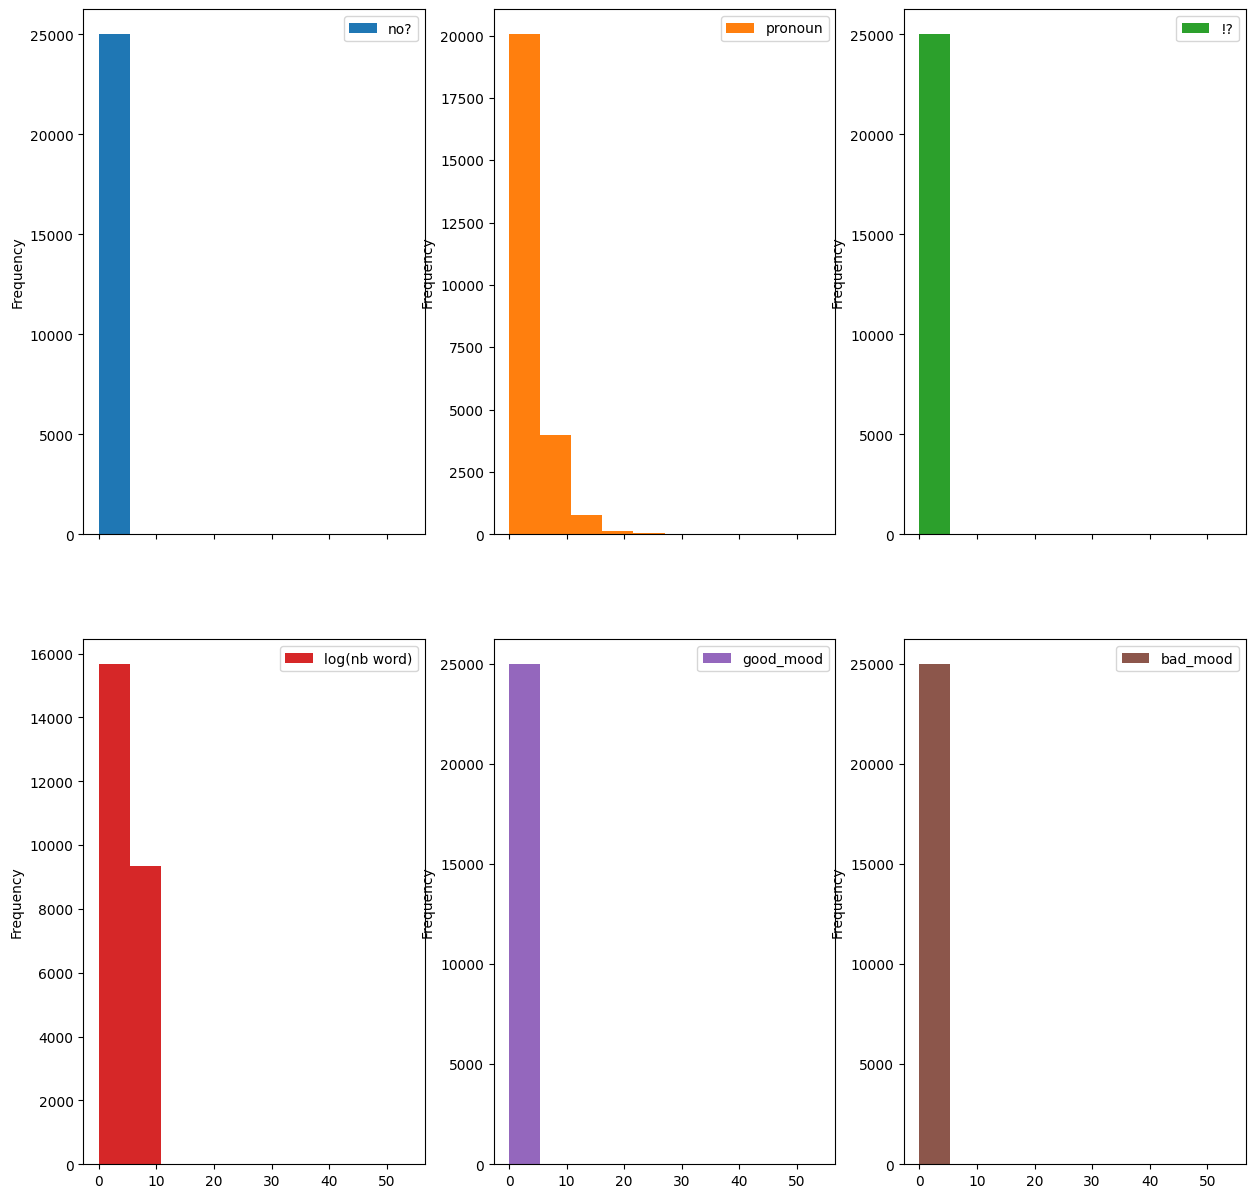

In [12]:
data_set.sort_values(by='good_mood', ascending=False, inplace=True)
data_set.drop('label', axis=1).plot.hist(subplots=True, layout=(2,3), figsize=(15,15))

La case précédente trace le graphe des features. Celles-ci sont pour toute quasiment représenté que par des 0, ce qui va rendre compliquer la classification.

Néanmoins les données ont l'air plûtot normalisé ce qui va simplifier la tâche.

In [14]:
data_set['!?'].value_counts()

0    20886
1     4114
Name: !?, dtype: int64

In [15]:
df = pd.DataFrame()
df["x"] = data_set['good_mood']
df["y"] = data_set['log(nb word)']
df["label"] = data_set['label']
df.head()

,x,y,label
20654,10,5.961005,1
11621,7,6.896694,0
14170,7,6.910751,1
16721,6,7.219642,1
20639,6,6.390241,1


<Axes: xlabel='x', ylabel='y'>

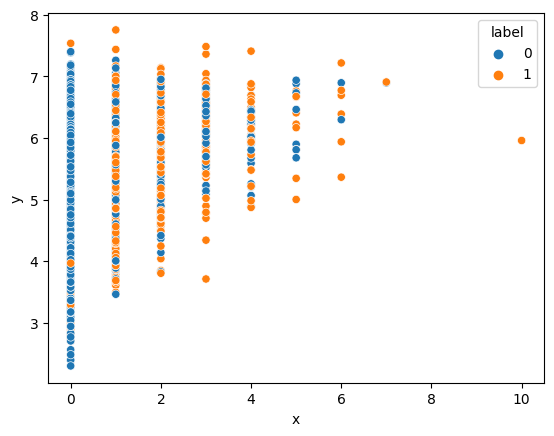

In [16]:
sns.scatterplot(data=df, x="x", y="y", hue="label")

## Train, test, and validation split

We need a test set to evaluate our final model, and a validation set to make sure we don't overfit to the training data.

In [56]:
all_points = torch.tensor(data_set.drop(['text', 'word list', 'label'], axis=1).to_numpy(), dtype=torch.float32)
labels = torch.tensor(data_set['label'].to_numpy(), dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

## Logisitic regression classifier

In [57]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

## Training the model

In [58]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [59]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.7306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6975, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6938, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6919, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6910, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6904, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6901, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6899, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6898, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6898, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 7.36 s, sys: 3.75 ms, total: 7.37 s
Wall time: 1.24 s


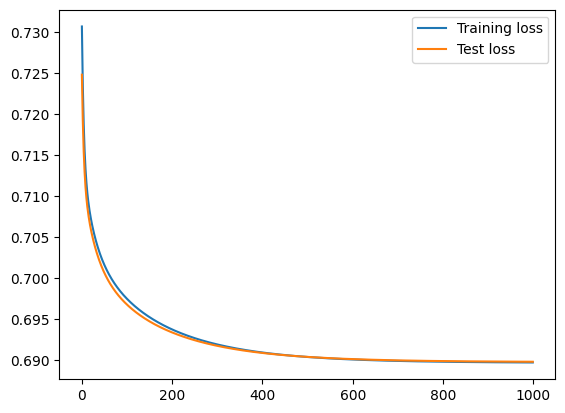

In [60]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [61]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(f"train: {training_accuracy}, validation: {valid_accuracy}, test: {test_accuracy}")

train: 0.5500625, validation: 0.542, test: 0.54


## Evaluate your classifier in terms of accuracy for the training, validation, and test set.

L'accuracy est d'environ 55% pour les trois sets (train: 0.5500625, validation: 0.542, test: 0.54)
Ce qui est vraiment très peu.

Nous pensons que les features ne décrivent pas suffisament bien le texte pour permettre une bonne classification

In [62]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]

(tensor([[-0.0523, -0.0256, -0.0075,  0.0168,  0.0314, -0.0038]]),
 tensor([0.0026]))

## Look at the weights of your classifier. Which features seems to play most for both classes?

Les classes qui ont l'air d'être le plus important sont la présence du mot 'no' pour la classe 0 et la présence de mots positifs du lexique vader pour la classe 1.

In [102]:
def wrong(nb: int):
    print(model.classifier(torch.tensor(data_set.drop(['text', 'word list', 'label'], axis=1).iloc[nb], dtype=torch.float32)))
    print(f"text: {data_set.iloc[nb].text} \nlabel: {data_set.iloc[nb].label}")
    print(data_set.drop(['text', 'word list', 'label'], axis=1).iloc[nb])
wrong(5000)

tensor([0.4893], grad_fn=<SigmoidBackward0>)
text: i got to see this on the plane to nz last weekand was wondering how it would measure up to both the uk film and the booki have to say i was favorable impressedif anything the fanatical attachment to the red sox during the lean years works even better than the original devotion to arsenal fcwho have had success through the yearsas a brit i was also interested to see that you don't need to understand baseball to get what's going onone question springs to mind was the screenplay written using the sox as the team even before they finally broke the curse of the bambinoor was another team in the frameas a red sox fan myself (weird i knowa brit who understands baseballi have to say that it added to the enjoyment 
label: 1
no?             0.000000
pronoun         5.000000
!?              0.000000
log(nb word)    4.912655
good_mood       0.000000
bad_mood        0.000000
Name: 15950, dtype: float64


## Take two wrongly classified samples in the test set and try explaining why the model was wrong.

Pour le premier exemple, il n'y a eu aucun mot positifs alors que la review était positive (voir print au dessus)

Le deuxième mal classifié a un mot positif et aucun no dans son text, ce qui fait qu'il est classifié comme positifs alors que non (voir print en dessous)

In [105]:
wrong(1936)

tensor([0.5050], grad_fn=<SigmoidBackward0>)
text: okthe portrayal of the stereotyped 'indiansin this story is just plain wrongi do agree that elvis looks rather good herebut yeahhis skin color does seem to change during the moviei was thinkingok,...he was never that tan in real lifeit's some of the most obvious brown 'indianmakeup that i have ever seenit's as bad as the 'indianson 'f-troopand the old hollywood westerns who were played by jewish and italian american actors and not real native americans!<br /><br />this movie is o.k.but typically lame story and mediocre songslike in all of elvislater filmshe just did them because colonel parker had him tied down to long term movie contacts to squeeze as much money out of elvis as possiblei keep thinking 'thank godthat elvis stopped making movies forever not long after this movie came outit is cool to see character actors joan blondellkaty juradol.qjoneshenry jones and burgess meredith in this moviethough.<br /><br />burgess meredith's '

In [97]:
data_set.sort_values(by="label")

,text,label,word list,no?,pronoun,!?,log(nb word),good_mood,bad_mood
10183,superdome is one of those movies that makes yo...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,4.094345,0,0
1933,reallyreally badhow does a film this bad get m...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4,0,4.882802,0,0
1934,if i could give it less that 1 i woulddo not b...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,9,0,5.476464,0,0
1935,i gave this two stars for the awesome dv shot ...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,3,0,4.615121,0,0
1936,while william shater can always make me smile ...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,3,1,5.068904,0,0
...,...,...,...,...,...,...,...,...,...
19725,small spoilers alert !!!<br /><br />good movie...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,4,1,5.733341,0,0
19726,to die for has it all.this film has a great ca...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,0,3.912023,0,0
19727,this film is available from david shepard and ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,6.317165,0,0
19744,unlike tinseltown's version of hellodolly!jay ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,1,5.613128,0,1


## Training model, but better

The best practice with PyTorch is to return the logits and not the results of the activation function. Doing so allows to use an [implementation trick](https://en.wikipedia.org/wiki/LogSumExp) which gives better stability at training. The following code uses this trick. It removes the activation function from the model and uses the corresponding ...WithLogitsLoss function.

In [74]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [25]:
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [75]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 6.03 s, sys: 107 µs, total: 6.03 s
Wall time: 1.01 s


Notice how the training was faster. This is due to the implementation trick.

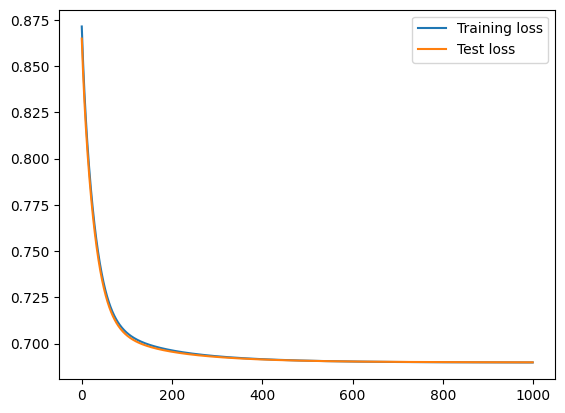

In [27]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [28]:
# Note that we need to use a sigmoid on the output now.
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.549875 0.542 0.541
